In [20]:
#imports
import pandas as pd
import numpy as np
import itertools 
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from scipy.stats import poisson
import warnings

warnings.filterwarnings("ignore")

In [21]:
#load in M.tb isolate information, one line per mutation per isolate. 
seq_treat_data=pd.read_csv('seq_treat_data_used.csv')

#make list of drug acronyms
drugs_to_test=['RIF', 'INH', 'PZA', 'ETH', 'LEV', 'MXF', 'AMI', 'CAP', 'KAN']

#report number of isolates with phenotypes for each drug
print(seq_treat_data.uniqueid.nunique())
n_drug=[]
n_r_drug=[]
for i in drugs_to_test:
    n_drug.append(seq_treat_data.loc[seq_treat_data.drug==i].uniqueid.nunique())
    n_r_drug.append(seq_treat_data.loc[(seq_treat_data.drug==i)&(seq_treat_data.phenotype=='R')].uniqueid.nunique())
n_df=pd.DataFrame(list(zip(drugs_to_test, n_drug, n_r_drug)), columns=['drug','n_isolates','n_resistant'])
n_df['percentage_resistant']=round(n_df.n_resistant/n_df.n_isolates*100,1)
n_df.to_csv('sample_nos.csv')
n_df

38111


,drug,n_isolates,n_resistant,percentage_resistant
0,RIF,34416,9869,28.7
1,INH,34440,12195,35.4
2,PZA,15934,2337,14.7
3,ETH,14009,2978,21.3
4,LEV,18386,3125,17.0
5,MXF,13440,1880,14.0
6,AMI,17093,1295,7.6
7,CAP,11622,974,8.4
8,KAN,16277,1488,9.1


In [22]:
#load mutations detected by moelcular diagnostic tests 
test_data=pd.read_csv('assay_mutations_list.csv')
#create gene+mutation columns for amino acid/nucleotide mutations  
test_data['geneXmutation']=test_data['Gene']+" "+test_data['Mutation']
#create gene+position columns for acid/nucleotide mutations
test_data['int_position']=test_data.Region.astype('Int64')
test_data['str_position']=test_data.int_position.astype('str')
geneXaa=[]
geneXn=[]
for index,row in test_data.iterrows():
    if row['aa']==1 and pd.isna(row['Mutation']):
        geneXaa.append(row['Gene']+" "+row['str_position'])
        geneXn.append(np.nan)
    elif row['n']==1 and pd.isna(row['Mutation']):
        geneXn.append(row['Gene']+" "+row['str_position'])
        geneXaa.append(np.nan)
    else:
        geneXaa.append(np.nan)
        geneXn.append(np.nan)
test_data['geneXaa']=geneXaa
test_data['geneXn']=geneXn

In [23]:
def mutations_list_performance(drug_code, test_name, mut_or_region):
    '''takes drug string (e.g. 'RIF'), name of drug susceptibility test e.g. 'GenoType MTBDRsl Ver 1.0', 
    and test interpretation to use (string 'mut' or 'region'),
    returns dataframe of performance of test mutations from test_data on the seq_treat_data dataframe'''
    

    t_data = test_data.loc[(test_data.Test==test_name)&(test_data.Drug==drug_code)]
    
    r_data=seq_treat_data.loc[(seq_treat_data.drug==drug_code)&(seq_treat_data.phenotype=='R')]
    s_data=seq_treat_data.loc[(seq_treat_data.drug==drug_code)&(seq_treat_data.phenotype=='S')]
    r_samples=r_data.uniqueid.nunique()
    s_samples=s_data.uniqueid.nunique()
    
    r_mutation_df=pd.DataFrame()
    s_mutation_df=pd.DataFrame()
    r_mutation_df = r_mutation_df.append(r_data.loc[((r_data.geneXmutation.notna())&(r_data.geneXmutation.isin(t_data['geneXmutation'].to_list())))])
    r_mutation_df = r_mutation_df.append(r_data.loc[((r_data.geneXnucleotidesnp.notna())&(r_data.geneXnucleotidesnp.isin(t_data['geneXmutation'].to_list())))])
    s_mutation_df = s_mutation_df.append(s_data.loc[((s_data.geneXmutation.notna())&(s_data.geneXmutation.isin(t_data['geneXmutation'].to_list())))])
    s_mutation_df = s_mutation_df.append(s_data.loc[((s_data.geneXnucleotidesnp.notna())&(s_data.geneXnucleotidesnp.isin(t_data['geneXmutation'].to_list())))])
    if mut_or_region=='region':
        s_mutation_df = s_mutation_df.append(s_data.loc[(seq_treat_data.is_null!=True)
                                                        &(seq_treat_data.is_filter_pass!=False)
                                                        &(seq_treat_data.is_het!=True)
                                                        &(s_data.position.notna())
                                                        &(-s_data.mutation.isin(t_data['Susceptible'].dropna().to_list()))
                                                        &((s_data.geneXaa.isin(t_data['geneXaa'].dropna().to_list()))|
                                                         (s_data.geneXnn.isin(t_data['geneXn'].dropna().to_list())))])
        r_mutation_df = r_mutation_df.append(r_data.loc[(seq_treat_data.is_null!=True)
                                                        &(seq_treat_data.is_filter_pass!=False)
                                                        &(seq_treat_data.is_het!=True)
                                                        &(r_data.position.notna())
                                                        &(-r_data.mutation.isin(t_data['Susceptible'].dropna().to_list()))
                                                        &((r_data.geneXaa.isin(t_data['geneXaa'].dropna().to_list()))|
                                                          (r_data.geneXnn.isin(t_data['geneXn'].dropna().to_list())))])            


    r_mutations= r_mutation_df.uniqueid.nunique()    
    s_mutations= s_mutation_df.uniqueid.nunique()
    sens=r_mutations/r_data.uniqueid.nunique()
    sens_lb=(2*r_samples*sens+3.8416-1-1.96*math.sqrt(3.8416-2-(1/r_samples)+4*sens*(r_samples*(1-sens)+1)))/(2*(r_samples+3.8416))
    sens_ub=(2*r_samples*sens+3.8416+1+1.96*math.sqrt(3.8416-2-(1/r_samples)+4*sens*(r_samples*(1-sens)+1)))/(2*(r_samples+3.8416))
    spec=(s_data.uniqueid.nunique()-s_mutations)/s_data.uniqueid.nunique()
    spec_lb=(2*s_samples*spec+3.8416-1-1.96*math.sqrt(3.8416-2-(1/s_samples)+4*spec*(s_samples*(1-spec)+1)))/(2*(s_samples+3.8416))
    spec_ub=(2*s_samples*spec+3.8416+1+1.96*math.sqrt(3.8416-2-(1/s_samples)+4*spec*(s_samples*(1-spec)+1)))/(2*(s_samples+3.8416))
    df = pd.DataFrame([{'Drug':drug_code,'Name':test_name, 
                       'No_R':r_samples, 'No_S':s_samples,
                       'R_mut':r_mutations,'S_mut':s_mutations,
                       'Sensitivity':sens, 'sens_LB':sens_lb, 'sens_UB':sens_ub, 'Specificity':spec, 
                        'spec_LB':spec_lb, 'spec_UB':spec_ub, 'Mut_or_Reg':mut_or_region}])
    return df

In [24]:
def mutations_cat_performance(drug_code):
    '''takes drug string (e.g. 'RIF'),
    returns dataframe of performance of catalogue on the seq_treat_data dataframe'''
    r_data=seq_treat_data.loc[(seq_treat_data.drug==drug_code)&(seq_treat_data.phenotype=='R')]
    r_samples=r_data.uniqueid.nunique()
    s_data=seq_treat_data.loc[(seq_treat_data.drug==drug_code)&(seq_treat_data.phenotype=='S')]
    s_samples=s_data.uniqueid.nunique()
    r_mutations = r_data.loc[r_data.cat==1].uniqueid.nunique()
    s_mutations = s_data.loc[s_data.cat==1].uniqueid.nunique()
    sens=r_mutations/r_data.uniqueid.nunique()
    sens_lb=(2*r_samples*sens+3.8416-1-1.96*math.sqrt(3.8416-2-(1/r_samples)+4*sens*(r_samples*(1-sens)+1)))/(2*(r_samples+3.8416))
    sens_ub=(2*r_samples*sens+3.8416+1+1.96*math.sqrt(3.8416-2-(1/r_samples)+4*sens*(r_samples*(1-sens)+1)))/(2*(r_samples+3.8416))
    spec=(s_data.uniqueid.nunique()-s_mutations)/s_data.uniqueid.nunique()
    spec_lb=(2*s_samples*spec+3.8416-1-1.96*math.sqrt(3.8416-2-(1/s_samples)+4*spec*(s_samples*(1-spec)+1)))/(2*(s_samples+3.8416))
    spec_ub=(2*s_samples*spec+3.8416+1+1.96*math.sqrt(3.8416-2-(1/s_samples)+4*spec*(s_samples*(1-spec)+1)))/(2*(s_samples+3.8416))
    df = pd.DataFrame([{'Drug':drug_code,'Name':"WHO 2021 catalogue", 
                       'No_R':r_samples, 'No_S':s_samples,
                       'R_mut':r_mutations,'S_mut':s_mutations,
                       'Sensitivity':sens, 'sens_LB':sens_lb, 'sens_UB':sens_ub, 'Specificity':spec, 
                        'spec_LB':spec_lb, 'spec_UB':spec_ub, 'Mut_or_Reg':'cat'}])
    return df

In [25]:
#run in silico analysis for catalogue and molecular diangsotic tests for each drug and save a file of the results
results_df = pd.DataFrame()
for i in drugs_to_test:
        results_df=results_df.append(mutations_cat_performance(i))
region_test_data=test_data.loc[test_data.Region.notna()]
mutation_test_data=test_data.loc[test_data.Mutation.notna()]
for i in mutation_test_data.Drug.unique():
    for j in mutation_test_data.loc[mutation_test_data.Drug==i].Test.unique():
        results_df=results_df.append(mutations_list_performance(i, j, 'mut'))
region_test_data=test_data.loc[test_data.Region.notna()]
for i in region_test_data.Drug.unique():
    for j in region_test_data.loc[region_test_data.Drug==i].Test.unique():
        results_df=results_df.append(mutations_list_performance(i, j, 'region'))
results_df.reset_index(drop=True, inplace=True) 
results_df.to_csv('in_silico_diagnostic_test_results.csv')

In [28]:
def sort_values(df, column_names, ascending=False, fixed=None):
    '''takes dataframe and column names to sort by, returns sorted dataframe'''
    if fixed is None:
        return df.sort_values(column_names, ascending=ascending)
    idx = df.index.get_indexer(fixed).tolist()
    s_df = df.sort_values(column_names, ascending=ascending).T
    keep_cols = s_df.columns.difference(fixed, sort=False)
    out = s_df[keep_cols]
    for (loc, name) in zip(idx, fixed):
        out.insert(loc, name, s_df[name])
    return out.T

In [29]:
#load in silico analysis results and clinical performance of molecular diagnostic tests
results_df=pd.read_csv('in_silico_diagnostic_test_results.csv')
clinical_perf=pd.read_csv('clinical_performance.csv')

In [ ]:
#make dictionaries for graphs
#assign a unique color to each test
colors=['black', 'purple', 'gold', 'blue',  'magenta', 'cyan', 'red', 'brown','orange' ,'royalblue',
        'lightblue','greenyellow','lightgreen', 'darkgreen', 'pink']
colors_dict = {results_df.Name.unique()[i]: colors[i] for i in range(len(results_df.Name.unique()))}
#assign hatching patterns to different interpretations
pattern_dict={'region':'///','mut':'', 'cat':''} 

In [ ]:
#make graph for first line drugs
drugs=['RIF','INH','PZA']
kws=[]
for i in drugs:
    kws.append(len(results_df.loc[(results_df.Drug==i)&(results_df.Sensitivity>0)]))



fig, axs = plt.subplots(len(drugs),2, 
                        gridspec_kw={'height_ratios': kws}, figsize=(8,sum(kws)/3), sharex=True)



for i in range(len(drugs)):
    label=[]
    pattern=[]
    graph_df = results_df.loc[(results_df.Drug==drugs[i])&(results_df.Sensitivity>0)]
    graph_df=sort_values(graph_df, ['Name', 'Mut_or_Reg'], ascending=True, fixed=graph_df.loc[graph_df.Mut_or_Reg=='cat'].index)
    name=graph_df.Name.to_list()
    mut_or_reg=graph_df.Mut_or_Reg.to_list()
    for iii in range(len(name)):
        label.append(graph_df.Name.to_list()[iii]+' '+graph_df.Mut_or_Reg.to_list()[iii])
   
    x_pos = [j for j, _ in enumerate(name)]
    sens=graph_df.Sensitivity*100
    spec=graph_df.Specificity*100
    sens_ci=(graph_df.Sensitivity-graph_df.sens_LB)*100
    spec_ci=(graph_df.Specificity-graph_df.spec_LB)*100
    colors=[]
    pattern=[]
    clinical_sens=[np.nan]
    clinical_spec=[np.nan]
    plt.rcParams['hatch.color'] = 'w' 
    for iii in range(len(name)):
        colors.append(colors_dict[name[iii]])
        pattern.append(pattern_dict[mut_or_reg[iii]])
        if name[iii]!='WHO 2021 catalogue':
            if len(clinical_perf.loc[(clinical_perf.Drug==drugs[i])& (clinical_perf.Test==name[iii])])>0:
                clinical_sens.append(clinical_perf.loc[(clinical_perf.Drug==drugs[i])& (clinical_perf.Test==name[iii])].Sensitivity.to_list()[0])
                clinical_spec.append(clinical_perf.loc[(clinical_perf.Drug==drugs[i])& (clinical_perf.Test==name[iii])].Specificty.to_list()[0])
            else:
                clinical_sens.append(np.nan)
                clinical_spec.append(np.nan)
    axs[ i, 0].barh(x_pos, sens, color=colors, hatch=pattern, xerr=sens_ci, ecolor='gray',zorder=1)
    axs[ i, 1].barh(x_pos, spec, color=colors, hatch=pattern, xerr=spec_ci, ecolor='gray',zorder=1)
    axs[i, 0].scatter(clinical_sens,x_pos, marker='o',color='#1C00ff00', edgecolors='gray',zorder=2)
    axs[i, 1].scatter(clinical_spec,x_pos, marker='o',color='#1C00ff00', edgecolors='gray',zorder=2)

    
    
    
    if i==0:
        axs[i,0].xaxis.set_ticks_position('top')
        axs[i,0].axes.set_xlabel('Sensitivity')
        axs[i,0].xaxis.set_label_position('top')
        axs[i,1].xaxis.set_ticks_position('top')
        axs[i,1].axes.set_xlabel('Specificity')
        axs[i,1].xaxis.set_label_position('top')
        
        for ii in ['left','right','bottom']:
            axs[i,0].spines[ii].set_visible(False)
            axs[i,1].spines[ii].set_visible(False)
        axs[i,0].axes.set_xlim(40,104)
    
        
    else:
        axs[i,0].axes.get_xaxis().set_visible(False)
        axs[i,1].axes.get_xaxis().set_visible(False)
        for ii in ['left','right','top','bottom']:
            axs[i,0].spines[ii].set_visible(False)
            axs[i,1].spines[ii].set_visible(False)
        axs[i,0].axes.set_xlim(40,104)

    axs[i,1].axes.get_yaxis().set_visible(False)
    axs[i,0].axes.set_ylabel(drugs[i], rotation=0, va='center', labelpad=20)
    axs[i,0].axes.set_yticks([])
    
    for index, value in enumerate(sens):
        axs[i,0].text(105, index, '{:0.1f}'.format(value))
        
    for index, value in enumerate(spec):
        axs[i,1].text(105, index, '{:0.1f}'.format(value))
    
    plt.tight_layout()
    
import matplotlib.patches as mpatches
patches = [] 
for i in results_df.loc[(results_df.Drug.isin(drugs))].Name.unique():
    patches.append(mpatches.Patch(color=colors_dict[i], label=i))

patches.append(mpatches.Patch( facecolor='w',label=''))
patches.append(mpatches.Patch( facecolor='grey',label='Resistance Detected (Specific Mutations Detected)'))
patches.append(mpatches.Patch( facecolor='grey',edgecolor='w',hatch='////',label='Resistance Inferred (Mutations Present Within Regions)'))

plt.legend(handles=patches, prop={'size': 9}, loc="upper center", bbox_to_anchor=(0, -0.2), ncol=3) 
       
plt.savefig('test_sens&spec_v3_fl.png', dpi=300, transparent=True, bbox_inches='tight')

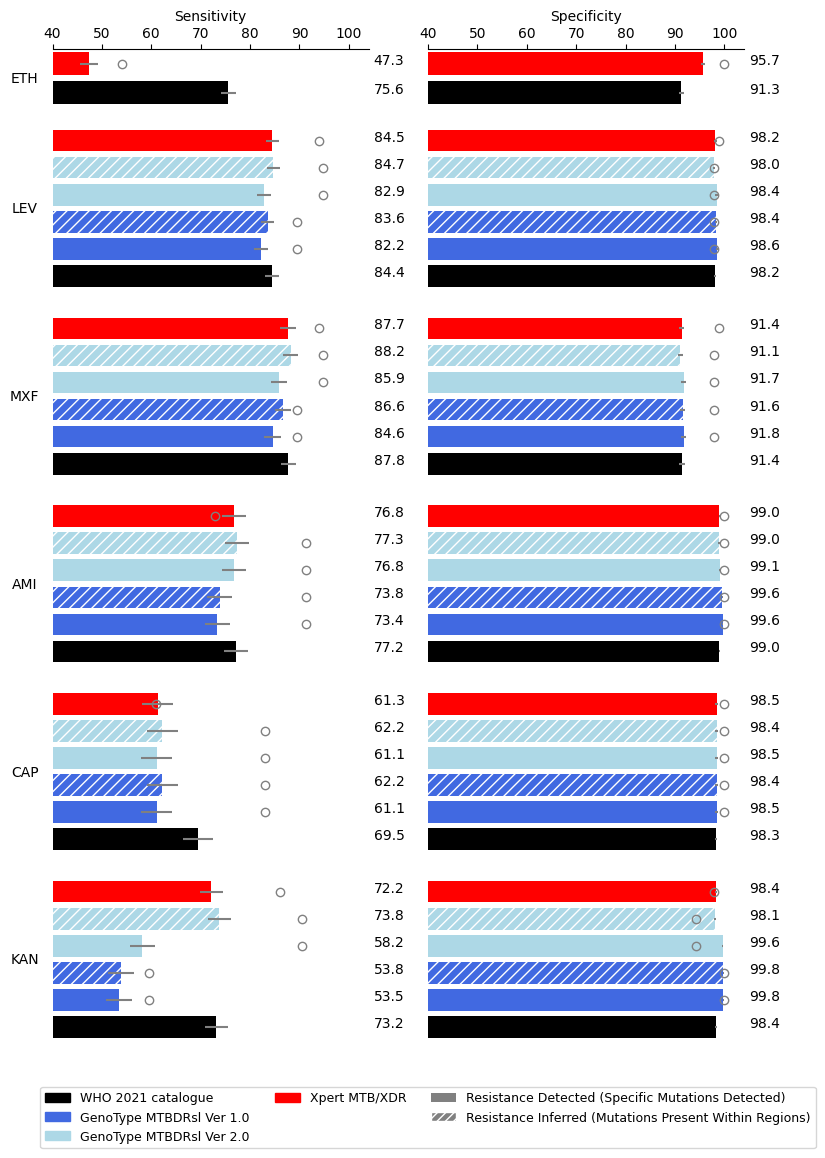

In [30]:
#make graph for second line drugs
drugs=['ETH','LEV','MXF','AMI','CAP','KAN']
kws=[]
for i in drugs:
    kws.append(len(results_df.loc[(results_df.Drug==i)&(results_df.Sensitivity>0)]))

fig, axs = plt.subplots(len(drugs),2, 
                        gridspec_kw={'height_ratios': kws}, figsize=(8,sum(kws)/3), sharex=True)



for i in range(len(drugs)):
    label=[]
    pattern=[]
    graph_df = results_df.loc[(results_df.Drug==drugs[i])&(results_df.Sensitivity>0)]
    graph_df=sort_values(graph_df, ['Name', 'Mut_or_Reg'], ascending=True, fixed=graph_df.loc[graph_df.Mut_or_Reg=='cat'].index)
    name=graph_df.Name.to_list()
    mut_or_reg=graph_df.Mut_or_Reg.to_list()
    for iii in range(len(name)):
        label.append(graph_df.Name.to_list()[iii]+' '+graph_df.Mut_or_Reg.to_list()[iii])
   
    x_pos = [j for j, _ in enumerate(name)]
    sens=graph_df.Sensitivity*100
    spec=graph_df.Specificity*100
    sens_ci=(graph_df.Sensitivity-graph_df.sens_LB)*100
    spec_ci=(graph_df.Specificity-graph_df.spec_LB)*100
    colors=[]
    pattern=[]
    clinical_sens=[np.nan]
    clinical_spec=[np.nan]
    plt.rcParams['hatch.color'] = 'w' 
    for iii in range(len(name)):
        colors.append(colors_dict[name[iii]])
        pattern.append(pattern_dict[mut_or_reg[iii]])
        if name[iii]!='WHO 2021 catalogue':
            if len(clinical_perf.loc[(clinical_perf.Drug==drugs[i])& (clinical_perf.Test==name[iii])])>0:
                clinical_sens.append(clinical_perf.loc[(clinical_perf.Drug==drugs[i])& (clinical_perf.Test==name[iii])].Sensitivity.to_list()[0])
                clinical_spec.append(clinical_perf.loc[(clinical_perf.Drug==drugs[i])& (clinical_perf.Test==name[iii])].Specificty.to_list()[0])
            else:
                clinical_sens.append(np.nan)
                clinical_spec.append(np.nan)
    axs[ i, 0].barh(x_pos, sens, color=colors, hatch=pattern, xerr=sens_ci, ecolor='gray',zorder=1)
    axs[ i, 1].barh(x_pos, spec, color=colors, hatch=pattern, xerr=spec_ci, ecolor='gray',zorder=1)
    axs[i, 0].scatter(clinical_sens,x_pos, marker='o',color='#1C00ff00', edgecolors='gray',zorder=2)
    axs[i, 1].scatter(clinical_spec,x_pos, marker='o',color='#1C00ff00', edgecolors='gray',zorder=2)
    
    
    
    if i==0:
        axs[i,0].xaxis.set_ticks_position('top')
        axs[i,0].axes.set_xlabel('Sensitivity')
        axs[i,0].xaxis.set_label_position('top')
        axs[i,1].xaxis.set_ticks_position('top')
        axs[i,1].axes.set_xlabel('Specificity')
        axs[i,1].xaxis.set_label_position('top')
        
        for ii in ['left','right','bottom']:
            axs[i,0].spines[ii].set_visible(False)
            axs[i,1].spines[ii].set_visible(False)
        axs[i,0].axes.set_xlim(40,104)
    
        
    else:
        axs[i,0].axes.get_xaxis().set_visible(False)
        axs[i,1].axes.get_xaxis().set_visible(False)
        for ii in ['left','right','top','bottom']:
            axs[i,0].spines[ii].set_visible(False)
            axs[i,1].spines[ii].set_visible(False)
        axs[i,0].axes.set_xlim(40,104)

    axs[i,1].axes.get_yaxis().set_visible(False)
    axs[i,0].axes.set_ylabel(drugs[i], rotation=0, va='center', labelpad=20)
    axs[i,0].axes.set_yticks([])
    
    for index, value in enumerate(sens):
        axs[i,0].text(105, index, '{:0.1f}'.format(value))
        
    for index, value in enumerate(spec):
        axs[i,1].text(105, index, '{:0.1f}'.format(value))
    
    plt.tight_layout()
    
import matplotlib.patches as mpatches
patches = [] 
for i in results_df.loc[(results_df.Drug.isin(drugs))].Name.unique():
    patches.append(mpatches.Patch(color=colors_dict[i], label=i))

patches.append(mpatches.Patch( facecolor='w',label=''))
patches.append(mpatches.Patch( facecolor='grey',label='Resistance Detected (Specific Mutations Detected)'))
patches.append(mpatches.Patch( facecolor='grey',edgecolor='w',hatch='////',label='Resistance Inferred (Mutations Present Within Regions)'))

plt.legend(handles=patches, prop={'size': 9}, loc="upper center", bbox_to_anchor=(0, -0.2), ncol=3) 
 

plt.savefig('test_sens&spec_v3_sl.png', dpi=300, transparent=True, bbox_inches='tight')